# **Importando a base**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U imbalanced-learn
!pip install feature-engine

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/credito/treino.csv', sep=',')

In [ ]:
!python --version

Python 3.7.11


# **Análise descritiva**

In [ ]:
print(f'A base contém {df.shape[0]} linhas e {df.shape[1]} colunas')

A base contém 110000 linhas e 11 colunas


In [ ]:
# Resumo estatístico
df.describe().round(1)

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,110000.0,110000.0,110000.0,110000.0,110000.0,88237.0,110000.0,110000.0,110000.0,110000.0,107122.0
mean,0.1,5.9,52.3,0.4,354.8,6637.4,8.4,0.3,1.0,0.2,0.8
std,0.2,252.3,14.8,4.2,2074.1,13384.0,5.1,4.2,1.1,4.2,1.1
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,41.0,0.0,0.2,3400.0,5.0,0.0,0.0,0.0,0.0
50%,0.0,0.2,52.0,0.0,0.4,5400.0,8.0,0.0,1.0,0.0,0.0
75%,0.0,0.6,63.0,0.0,0.9,8225.0,11.0,0.0,2.0,0.0,1.0
max,1.0,50708.0,109.0,98.0,329664.0,3008750.0,58.0,98.0,54.0,98.0,20.0


In [ ]:
# Metadados da base
df.dtypes

inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object

In [ ]:
# Contagem da variável target
df.inadimplente.value_counts()

0    102669
1      7331
Name: inadimplente, dtype: int64

In [ ]:
# Contagem da variável target em %
df.inadimplente.value_counts(normalize=True)*100

0    93.335455
1     6.664545
Name: inadimplente, dtype: float64

In [ ]:
# Quantidade de nulos em cada coluna
df.isnull().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

# **Tratando valores nulos**

In [ ]:
df.query('salario_mensal <= 0')

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
14,0,0.019657,76,0,477.0,0.0,6,0,1,0,0.0
50,0,0.818978,73,0,3095.0,0.0,9,0,1,1,0.0
73,0,0.059669,31,0,3162.0,0.0,11,0,2,0,1.0
90,0,0.039388,51,0,15466.0,0.0,7,0,0,0,0.0
298,0,0.085152,25,0,1005.0,0.0,5,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
108994,0,0.001706,74,0,15.0,0.0,10,0,0,0,0.0
109207,0,0.676427,46,0,2527.0,0.0,13,0,1,0,0.0
109243,0,0.020704,39,0,1403.0,0.0,3,0,1,0,0.0
109510,0,0.240635,55,0,54.0,0.0,3,0,0,0,0.0


In [ ]:
# Pessoas com valores nulos em "num de dependentes" também possuem nulo no salário
df[df['numero_de_dependentes'].isnull()]['salario_mensal'].sum()

0.0

In [ ]:
# Retirando registros com salários nulos
df_notnull = df[~df.salario_mensal.isnull()]


# Criando um dict para guardar a média de renda por idade.
dict_idade_renda = df_notnull[['idade','salario_mensal']].groupby('idade').median().to_dict()['salario_mensal']


# Recolocar os valores da média de salário por idade no lugar dos nulos.
df.salario_mensal.fillna(df['idade'].map(dict_idade_renda), inplace=True)


# Algumas idades não puderam ter a mediana calculada por conter apenas uma amostra na base, estas serão substituídas com média geral.
df.salario_mensal.fillna(df['idade'].median(), inplace=True)


# Removendo registros nulos da coluna de numero de dependentes
df.dropna(axis=0, subset=['numero_de_dependentes'], inplace=True)

In [ ]:
# Conferindo a base após o tratamento de nulos
df.isna().sum()

inadimplente                             0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64

# **Tratando idade nula**

In [ ]:
df[df.idade==0]

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
65695,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [ ]:
# Removendo este registro por conter valor de idade igual a zero
df.drop(65695, inplace=True)

# **Analisando as features**

    O objetivo é verificar se podemos desconsiderar algumas das features caso elas tenham algumas das seguintes condições:
    1. Baixa variabilidade
    2. Alta correlação com alguma outra feature


In [ ]:
df_corr = df.drop(columns='inadimplente').corr().round(2)

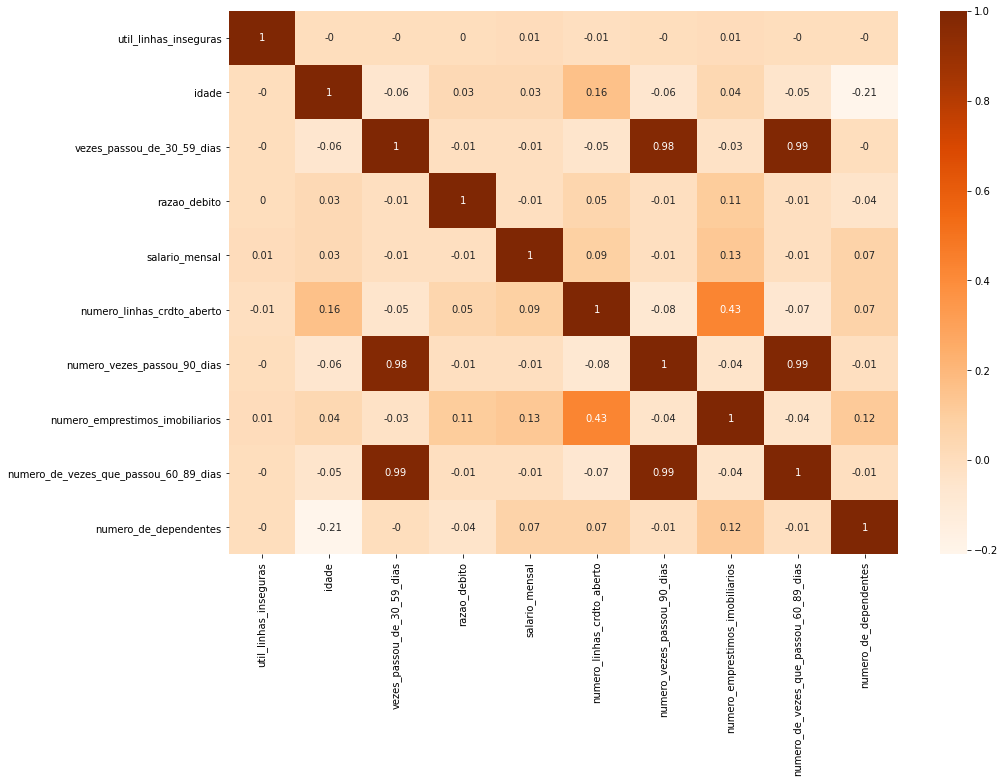

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df_corr, annot=True, cmap='Oranges');

As features de atraso no pagamento estão altamente correlacionadas !

Para evitar excluir informação de alguma delas, vou criar uma nova coluna que some todas as vezes que o cliente deixou de pagar independentemente do prazo.

In [ ]:
# Somando todas as vezes que o cliente atrasou o pagamento
df['num_atrasos_pagamento'] = df[['vezes_passou_de_30_59_dias', 
                                  'numero_de_vezes_que_passou_60_89_dias', 
                                  'numero_vezes_passou_90_dias']].sum(axis=1)

In [ ]:
# Removendo as features de atraso em cada prazo
df.drop(['vezes_passou_de_30_59_dias', 
         'numero_de_vezes_que_passou_60_89_dias', 
         'numero_vezes_passou_90_dias'], axis=1, inplace=True)

In [ ]:
df.head(10)

,inadimplente,util_linhas_inseguras,idade,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_emprestimos_imobiliarios,numero_de_dependentes,num_atrasos_pagamento
0,1,0.766127,45,0.802982,9120.0,13,6,2.0,2
1,0,0.957151,40,0.121876,2600.0,4,0,1.0,0
2,0,0.658180,38,0.085113,3042.0,2,0,0.0,2
3,0,0.233810,30,0.036050,3300.0,5,0,0.0,0
4,0,0.907239,49,0.024926,63588.0,7,1,0.0,1
5,0,0.213179,74,0.375607,3500.0,3,1,1.0,0
6,0,0.305682,57,5710.000000,6451.0,8,3,0.0,0
7,0,0.754464,39,0.209940,3500.0,8,0,0.0,0
9,0,0.189169,57,0.606291,23684.0,9,4,2.0,0
10,0,0.644226,30,0.309476,2500.0,5,0,0.0,0


# **Criação base de treino e validação**

In [ ]:
# Definindo features e target
target   = 'inadimplente'
features = [x for x in df.columns if x != target]

X = df.filter(features)
y = df[target]

In [ ]:
# Selecionando base de treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Vamos definir uma variável para armazenar as métricas de cada modelo:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score

score_list = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc']

metrics = {
    'model'       : [],
    'accuracy'    : [],
    'bl_accuracy' : [],
    'precision'   : [],
    'recall'      : [],
    'f1-score'    : [],
    'AUC'         : []
}

# Definindo uma função pra incluir as métricas no dicionário depois de rodar cada modelo de classificação
def save_metrics(y_test, y_pred, y_prob, model_name):

    metrics['model'].append(model_name)
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['bl_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['f1-score'].append(f1_score(y_test, y_pred))
    metrics['AUC'].append(roc_auc_score(y_test, y_prob[:,1]))

# **Rodando modelos**

In [ ]:
# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Pre-Processamento
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper

## # Logistic Regression

In [ ]:
lr = Pipeline(
    steps = [
        ('scaling', SklearnTransformerWrapper(transformer=StandardScaler(), variables=features)),
        ('lr',LogisticRegression(random_state=42, max_iter=500))]
        )


lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)

save_metrics(y_test,y_pred,y_prob,'Logistic Regression')

## # Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)

save_metrics(y_test, y_pred, y_prob, 'Decision Tree')

## # Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

save_metrics(y_test, y_pred, y_prob, 'Random Forest')

## # Gradient boosting

In [ ]:
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)

save_metrics(y_test,y_pred,y_prob,'Gradient Boosting')

## Avaliando métricas

## Testando diferentes % da base para treino (Learning Curve)

In [ ]:
# Quantidade de proporções da base de treino para testar.
train_sizes = np.linspace(start=0.5, stop=0.9, num=5)

models = [(lr,'Logistic Regression'), (dt, 'Decision Tree'), (rf, 'Random Forest'), (gb, 'Gradient Boosting')]

fig, axes = plt.subplots(3,4, figsize=(30,15))

for model in models:

    #Pegar a posição do modelo na lista
    model_num = models.index(model)

    # Calculando os números da learning curve
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator=model[0], 
                                                                          X=X, 
                                                                          y=y, 
                                                                          train_sizes=train_sizes, 
                                                                          cv=10, 
                                                                          return_times=True, 
                                                                          random_state=42)


    #Calcular as médias de cada rodada da validação cruzada
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)


    # Plotar a curva
    axes[0,model_num].grid()
    axes[0,model_num].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0,model_num].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0,model_num].fill_between(train_sizes,
                                   train_scores_mean - train_scores_std,
                                   train_scores_mean + train_scores_std,
                                   alpha=0.1,
                                   color="r")
    axes[0,model_num].fill_between(train_sizes,
                                   test_scores_mean - test_scores_std,
                                   test_scores_mean + test_scores_std, alpha=0.1,
                                   color="g")
    axes[0,model_num].legend(loc="best")
    axes[0,model_num].set_title('Modelo: ' + model[1], fontsize=15)
    axes[0,model_num].set_xlabel('Training Sample')
    axes[0,model_num].set_ylabel('Score')


    # Plotar qtde amostral vs tempo de treino
    axes[1,model_num].grid()
    axes[1,model_num].plot(train_sizes, fit_times_mean, 'o-')
    axes[1,model_num].fill_between(train_sizes,
                                   fit_times_mean - fit_times_std,
                                   fit_times_mean + fit_times_std,
                                   alpha=0.1)
    axes[1,model_num].set_xlabel("Training examples")
    axes[1,model_num].set_ylabel("fit_times")
    axes[1,model_num].set_title("Scalability of the model", fontsize=15)


    # Plotar score vs tempo de treino
    axes[2,model_num].grid()
    axes[2,model_num].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2,model_num].fill_between(fit_times_mean,
                                   test_scores_mean - test_scores_std,
                                   test_scores_mean + test_scores_std,
                                   alpha=0.1)
    axes[2,model_num].set_xlabel("fit_times")
    axes[2,model_num].set_ylabel("Score")
    axes[2,model_num].set_title("Performance of the model", fontsize=15)

plt.subplots_adjust(hspace=0.4)
plt.show()

# Obrigado scikit-learn pelo material: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

## **Conclusão:**

O modelo de regressão logística apresentou um pico de score com 80% da base sendo utilizada para treino enquanto os demais modelos de árvore e ensemble não apresentaram grandes destaques. vale mencionar a melhora no score do modelo Gradient Boosting com o acréscimo da quantidade treinada.

Por fim, dado está análise iremos manter o valor de **80% da base de treino.**

# **Validação cruzada**

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv = cross_validate(lr, X=X, y=y, scoring=score_list, cv=skf)

In [ ]:
# Olhando métricas do cv
pd.DataFrame(cv)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,0.384764,0.199473,0.932742,0.504164,0.481481,0.009028,0.017723,0.659855
1,0.429633,0.207416,0.932972,0.507511,0.547619,0.015972,0.031039,0.645479
2,0.447719,0.200233,0.933159,0.506966,0.617647,0.014583,0.028494,0.661190
3,0.410222,0.199895,0.933019,0.507858,0.558140,0.016667,0.032367,0.653043
4,0.409869,0.216498,0.933112,0.506277,0.593750,0.013204,0.025833,0.654645


In [ ]:
# Construí uma função pra facilitar o preenchimento das métricas dentro do dicionário depois do cross validation
def save_metrics_crossval(model_instance, features, target, scores_list, model_name):

    cv_results = cross_validate(model_instance,
                                features,
                                target,
                                scoring=scores_list,
                                cv=skf,
                                n_jobs=-1)

    cv_results_df = pd.DataFrame(cv_results).mean().round(5)

    metrics['model'].append(model_name)
    metrics['accuracy'].append(cv_results_df['test_accuracy'])
    metrics['bl_accuracy'].append(cv_results_df['test_balanced_accuracy'])
    metrics['precision'].append(cv_results_df['test_precision'])
    metrics['recall'].append(cv_results_df['test_recall'])
    metrics['f1-score'].append(cv_results_df['test_f1'])
    metrics['AUC'].append(cv_results_df['test_roc_auc'])

In [ ]:
# Salvando todas as métricas de cada modelo criado anteriormente
save_metrics_crossval(lr, X, y, score_list,'Logistic Regression CV')
save_metrics_crossval(dt, X, y, score_list,'Decision Tree CV')
save_metrics_crossval(rf, X, y, score_list,'Random Forest CV')
save_metrics_crossval(gb, X, y, score_list,'Gradient Boosting CV')

In [ ]:
# Olhar as métricas
pd.DataFrame(metrics).sort_values('model')

,model,accuracy,bl_accuracy,precision,recall,f1-score,AUC
1,Decision Tree,0.894796,0.605294,0.244668,0.270833,0.257086,0.605173
5,Decision Tree CV,0.894250,0.604760,0.242680,0.270310,0.255710,0.605380
3,Gradient Boosting,0.936289,0.587905,0.581699,0.185417,0.281201,0.861268
7,Gradient Boosting CV,0.936300,0.581020,0.590400,0.170580,0.264610,0.860710
0,Logistic Regression,0.932975,0.506544,0.555556,0.013889,0.027100,0.653751
4,Logistic Regression CV,0.933000,0.506560,0.559730,0.013890,0.027090,0.654840
2,Random Forest,0.933676,0.575227,0.521348,0.161111,0.246154,0.838997
6,Random Forest CV,0.934800,0.578800,0.549610,0.167520,0.256610,0.833520


# Rebalanceando variável target

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

os = RandomOverSampler(random_state=42, sampling_strategy=0.2)
us = RandomUnderSampler(random_state=42, sampling_strategy=0.8)
sm = SMOTE(random_state=42, sampling_strategy=0.2)

In [ ]:
# Testar diferentes métodos de reamostragem
X_over, y_over   = os.fit_resample(X_train, y_train)
X_under, y_under = us.fit_resample(X_train, y_train)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
X_sm_us, y_sm_us = us.fit_resample(X_smote, y_smote)

tpl = [(X_over, y_over, 'OverSampled'), (X_under, y_under, 'UnderSampled'), (X_smote, y_smote, 'SMOTE'), (X_sm_us, y_sm_us, 'SMOTE-UnderSampled')]

In [ ]:
# Loop para rodar os 4 modelos em cada uma das 4 bases (X,y) rebalanceadas
for a,b,c in tpl:

    X_treino, X_teste, y_treino, y_teste = train_test_split(a, b, test_size=0.2, random_state=42)


    lr.fit(X_treino, y_treino)
    y_pred = lr.predict(X_teste)
    y_prob = lr.predict_proba(X_teste)
    model_name = 'Logistic Regression ' + c
    save_metrics(y_teste,y_pred, y_prob, model_name=model_name)
    

    dt.fit(X_treino, y_treino)
    y_pred = dt.predict(X_teste)
    y_prob = dt.predict_proba(X_teste)
    model_name = 'Decision Tree ' + c
    save_metrics(y_teste, y_pred, y_prob, model_name=model_name)


    rf.fit(X_treino, y_treino)
    y_pred = rf.predict(X_teste)
    y_prob = rf.predict_proba(X_teste)
    model_name = 'Random Forest ' + c
    save_metrics(y_teste, y_pred, y_prob, model_name=model_name)


    gb.fit(X_treino, y_treino)
    y_pred = gb.predict(X_teste)
    y_prob = gb.predict_proba(X_teste)
    model_name = 'Gradient Boosting ' + c
    save_metrics(y_teste, y_pred, y_prob, model_name=model_name)

In [ ]:
# Olhando as métricas
pd.DataFrame(metrics)

,model,accuracy,bl_accuracy,precision,recall,f1-score,AUC
0,Logistic Regression,0.932975,0.506544,0.555556,0.013889,0.027100,0.653751
1,Decision Tree,0.894796,0.605294,0.244668,0.270833,0.257086,0.605173
2,Random Forest,0.933676,0.575227,0.521348,0.161111,0.246154,0.838997
3,Gradient Boosting,0.936289,0.587905,0.581699,0.185417,0.281201,0.861268
4,Logistic Regression CV,0.933000,0.506560,0.559730,0.013890,0.027090,0.654840
5,Decision Tree CV,0.894250,0.604760,0.242680,0.270310,0.255710,0.605380
6,Random Forest CV,0.934800,0.578800,0.549610,0.167520,0.256610,0.833520
7,Gradient Boosting CV,0.936300,0.581020,0.590400,0.170580,0.264610,0.860710
8,Logistic Regression OverSampled,0.839719,0.508002,0.825397,0.016688,0.032715,0.725548
9,Decision Tree OverSampled,0.930467,0.927578,0.724320,0.923299,0.811795,0.927980


In [ ]:
# Salvando todas as métricas de cada modelo criado anteriormente
save_metrics_crossval(lr, X_smote, y_smote, score_list, 'Logistic Regression SMOTE CV')
save_metrics_crossval(dt, X_smote, y_smote, score_list, 'Decision Tree SMOTE CV')
save_metrics_crossval(rf, X_smote, y_smote, score_list, 'Random Forest SMOTE CV')
save_metrics_crossval(gb, X_smote, y_smote, score_list, 'Gradient Boosting SMOTE CV')

In [ ]:
# Olhando as novas métricas
pd.DataFrame(metrics).sort_values('recall', ascending=False)

,model,accuracy,bl_accuracy,precision,recall,f1-score,AUC
9,Decision Tree OverSampled,0.930467,0.927578,0.724320,0.923299,0.811795,0.927980
10,Random Forest OverSampled,0.968778,0.949801,0.889991,0.921694,0.905565,0.979704
22,Random Forest SMOTE-UnderSampled,0.846122,0.844779,0.827130,0.831478,0.829298,0.918828
23,Gradient Boosting SMOTE-UnderSampled,0.840284,0.835763,0.843946,0.790971,0.816600,0.916291
21,Decision Tree SMOTE-UnderSampled,0.783014,0.782609,0.748736,0.778602,0.763377,0.782825
15,Gradient Boosting UnderSampled,0.776235,0.769392,0.775878,0.703704,0.738031,0.852343
14,Random Forest UnderSampled,0.761574,0.754083,0.760807,0.682171,0.719346,0.837600
17,Decision Tree SMOTE,0.874016,0.786393,0.603006,0.656611,0.628668,0.786470
13,Decision Tree UnderSampled,0.684799,0.681382,0.648021,0.648579,0.648300,0.681690
25,Decision Tree SMOTE CV,0.873150,0.780550,0.614370,0.641650,0.627700,0.780790


# Ajuste de hiper-parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_sm_us, y_sm_us, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

In [ ]:
# Definindo a grade de parâmetros para teste

lr_params = {
    'solver': ['lbfgs', 'sag', 'saga']
}

dt_params = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

rf_params = {
    'n_estimators' : [150,200,250],
    'max_features' : [3,4,5],
    'max_depth'    : [16,20,24]
}

gb_params = {
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators'  : [100, 200, 300]
}

In [ ]:
# Resultado do tuning de parâmetros no GradientBoosting

grid_search = GridSearchCV(rf, rf_params, scoring = 'recall')

grid_search.fit(X_sm_us, y_sm_us)

results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
# Mostrar as 5 melhores configuraçoes do modelo
results.iloc[:,4:].sort_values('rank_test_score').head()

,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,20,3,200,"{'max_depth': 20, 'max_features': 3, 'n_estima...",0.641226,0.706287,0.893338,0.896185,0.895872,0.806582,0.110390,1
18,24,3,150,"{'max_depth': 24, 'max_features': 3, 'n_estima...",0.633406,0.708164,0.897091,0.897436,0.896811,0.806582,0.113370,2
19,24,3,200,"{'max_depth': 24, 'max_features': 3, 'n_estima...",0.636534,0.706913,0.898029,0.897123,0.893996,0.806519,0.112296,3
20,24,3,250,"{'max_depth': 24, 'max_features': 3, 'n_estima...",0.633094,0.708789,0.898342,0.896185,0.893684,0.806019,0.112868,4
11,20,3,250,"{'max_depth': 20, 'max_features': 3, 'n_estima...",0.636221,0.703785,0.893963,0.898687,0.896811,0.805893,0.113002,5


# Escolhendo o melhor modelo

In [ ]:
# Mostrar o melhor de todos
grid_search.best_estimator_

RandomForestClassifier(max_depth=20, max_features=3, n_estimators=200,
                       random_state=42)

In [ ]:
# Pegando as métricas do modelo já tunado
rf = grid_search.best_estimator_

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

save_metrics(y_test, y_pred, y_prob, 'Random Forest OverUnderSampled Tuned')

In [ ]:
# Feature Importance do melhor modelo
pd.DataFrame({
    'dt' : dt.feature_importances_,
    'rf' : rf.feature_importances_,
    'gb' : gb.feature_importances_}
)

In [ ]:
# Feature Importance do melhor modelo
pd.DataFrame({
    'features' : X_train.columns,
    'ft_importance' : rf.feature_importances_}
)

,features,ft_importance
0,util_linhas_inseguras,0.255650
1,idade,0.098066
2,razao_debito,0.114635
3,salario_mensal,0.109654
4,numero_linhas_crdto_aberto,0.065842
5,numero_emprestimos_imobiliarios,0.030893
6,numero_de_dependentes,0.121693
7,num_atrasos_pagamento,0.203567


In [ ]:
# Salvando os resultados

pd.DataFrame(metrics).to_excel('/content/drive/MyDrive/datasets/credito/tb-compare-models.xlsx', sheet_name = 'compare_model')

results.to_excel('/content/drive/MyDrive/datasets/credito/tb-rf-hypertuning.xlsx', sheet_name = 'tuning-metrics')

# Testando o modelo na base de teste !

In [ ]:
df_teste = pd.read_csv('/content/drive/MyDrive/datasets/credito/teste.csv', sep=',')
df_teste.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0


In [ ]:
# Tratando a base de teste
df_teste.salario_mensal.fillna(df_teste['idade'].map(dict_idade_renda), inplace=True)

df_teste.dropna(axis=0, subset=['salario_mensal','numero_de_dependentes'], inplace=True)

df_teste['num_atrasos_pagamento'] = df_teste[['vezes_passou_de_30_59_dias','numero_de_vezes_que_passou_60_89_dias','numero_vezes_passou_90_dias']].sum(axis = 1)

df_teste.drop(['vezes_passou_de_30_59_dias',
               'numero_de_vezes_que_passou_60_89_dias',
               'numero_vezes_passou_90_dias'],
              axis = 1,
              inplace = True)

In [ ]:
# Rodar o melhor no mdelo na base teste
X = df_teste.filter(features)

df_teste['prob_inadimplente'] = rf.predict_proba(X)[:,1]

df_teste.head()

,util_linhas_inseguras,idade,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_emprestimos_imobiliarios,numero_de_dependentes,num_atrasos_pagamento,prob_inadimplente
0,0.025849,62,0.081775,8180.0,3,2,0.0,0,0.013649
1,0.667083,55,0.153112,2200.0,3,0,0.0,0,0.186644
2,0.007093,44,0.148800,7499.0,20,1,0.0,0,0.035957
3,0.091213,54,0.351635,5900.0,15,1,0.0,1,0.265404
4,0.112680,54,0.065959,2167.0,3,0,0.0,0,0.221784


In [ ]:
# Exportar resultado com probabilidades de inadimplência, calculadas por cliente
df_teste.to_excel('/content/drive/MyDrive/datasets/credito/tb-predictions.xlsx', sheet_name = 'predictions')